In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random

import colorcet as cc
from scipy.stats import norm

%matplotlib inline

## Data mining

In [212]:
from selenium import webdriver
import wget
from os import path,mkdir,listdir

#Get information about all reports available
op = webdriver.ChromeOptions()
op.add_argument('headless')
driver = webdriver.Chrome(options=op)
driver.get('https://www.bcb.gov.br/publicacoes/focus/cronologicos')

html = driver.page_source

report_dates =  re.findall(r'[Relatório Focus,Relatório de Mercado] - (\d{2}/\d{2}/\d{4})',html)

#Check dir reports 
if not path.exists('reports'): mkdir('reports')
#Download all reports - if you have old reports in the folder reports, it will download only the missing reports
filenames =['R'+str.join('',dates.split('/')[::-1]) for dates in report_dates] 
for files in set([f+'.pdf' for f in filenames]) - set(listdir('reports/')): wget.download(f'https://www.bcb.gov.br/content/focus/focus/{files}', out=f'reports\\{files}')

In [2]:
from os import path,mkdir,listdir
import pdfplumber
import pytesseract
import cv2
from pdf2image import convert_from_path
from tqdm.auto import tqdm
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [46]:
ocr_op   = r'--oem 3 --psm 3' #OCR config
df = pd.DataFrame(columns=['Date','Indicator','Value','Year','Forecast_year_advance','OCR'])
count = 0
list_files = [file for file in listdir('reports/') if re.match(r'R\d{8}.pdf',file)]

#Check dir data 
if not path.exists('data'): mkdir('data')

for files in tqdm(list_files):
    #Read the text in the pdf - Before 20180622 the data were in page 2, in the new template the data are in page 1
    date = int(files[1:-4])
    #print(date)
    pdf = pdfplumber.open(f"reports\\{files}")
    if date<=20180622: page = pdf.pages[1]
    else: page = pdf.pages[0]
    text = page.extract_text()
    pdf.close()
    
    #Probably due to some enconding issues, when reading some files (using pdfplumber or pypdf) we get some error and the text is gibberish. To solve this issue, we use OCR to obtain the text when the text have (cid:...).
    if '(cid:' not in text[:100] and int(str(date)[-4:]) > 108 : 
        for patt,indicator in zip(['(?:IPCA \(%\)|IPCA \(variação %\))','(?:Câmbio|Taxa de câmbio - fim)','(?:PIB Total|PIB \(%)'],['IPCA','USD','GDP']):
            #find_value = re.findall(patt+r'.*? (\-?\d+,\d+)(?: \S+)? \(.+?\) .*? (\-?\d+,\d+)(?: \S+)? \(.+?\)', text) -- works except for negative values
            find_value = re.findall(patt+r'.*? (-?\d+,\d+)(?: \S? )? ?\(.+?\) .*? (-?\d+,\d+)(?: \S ?)? ?\(.+?\)', text)
            if(len(find_value)>0):
                report_value = [[date,indicator,int(re.sub('[\,,.]','',fvalue))/100,int(str(date)[:4])+years,years,0] for years,fvalue in enumerate(find_value[0])]
                df = pd.concat([df,pd.DataFrame(report_value,columns=['Date','Indicator','Value','Year','Forecast_year_advance','OCR'])])

    elif int(str(date)[-4:]) < 1215 and int(str(date)[-4:]) > 108 :      #The reports with date close to December 31 don't have any exchange rate, so to avoid any issue with OCR getting wrong data, we avoid those reports alltogether
        images = convert_from_path(f"reports\\{files}",dpi=400)
        image = images[0]

        image = image.convert('L')
        image_array = np.array(image)
        image_array = cv2.resize(image_array, (0, 0), fx=0.55, fy=0.55)

        text = pytesseract.image_to_string(image_array,config= ocr_op,lang='eng')

        for patt,indicator in zip(['(?:IPCA \(%\)|IPCA \(v)','(?:Câm|Cam|Taxa de)','(?:PIB T|PIB \(%)'],['IPCA','USD','GDP']):
            find_value = re.findall(patt+r'.*?(\d+(?:,|\.)?\d+)(?: \S+)? \( ?\d+ ?\) .*?(\d+(?:,|\.)?\d+)(?: \S+)? \( ?\d+ ?\)', text) 
            if(len(find_value)>0):
                report_value = [[date,indicator,int(re.sub('[\,,.]','',fvalue))/100,int(str(date)[:4])+years,years,1] for years,fvalue in enumerate(find_value[0])]
                df = pd.concat([df,pd.DataFrame(report_value,columns=['Date','Indicator','Value','Year','Forecast_year_advance','OCR'])])

df.to_csv('data/forecast_data.csv',index=False)       

  0%|          | 0/997 [00:00<?, ?it/s]

In [41]:
pdf = pdfplumber.open(f"reports\\R20161209.pdf")
page = pdf.pages[1]
text = page.extract_text()
pdf.close()

In [42]:
print(text)

Focus - Relatório de Mercado
9 de dezembro de 2016
Expectativas de Mercado
2016 2017
Mediana - agregado
Há 4 Comportamento Há 4 Comportamento
Há 1 semana Hoje Há 1 semana Hoje
semanas semanal* semanas semanal*
IPCA (%) 6,84 6,69 6,52 (5) 4,93 4,93 4,90 (1)
IGP-DI (%) 7,06 6,76 6,76 (1) 5,30 5,04 5,04 (1)
IGP-M (%) 7,36 6,98 7,04 (1) 5,33 5,22 5,06 (1)
IPC-Fipe (%) 6,59 6,31 6,30 (2) 5,06 5,12 5,39 (2)
Taxa de câmbio - fim de período (R$/US$) 3,22 3,35 3,39 (1) 3,40 3,45 3,45 (1)
Taxa de câmbio - média do período (R$/US$) 3,43 3,46 3,46 (1) 3,32 3,41 3,41 (1)
Meta Taxa Selic - fim de período (%a.a.) 13,75 - - 10,75 10,50 10,50 (1)
Meta Taxa Selic - média do período (%a.a.) 14,16 - - 11,63 11,69 11,63 (1)
Dívida Líquida do Setor Público (% do PIB) 45,42 45,20 45,20 (1) 50,10 50,70 51,00 (1)
PIB (% do crescimento) -3,37 -3,43 -3,48 (1) 1,13 0,80 0,70 (8)
Produção Industrial (% do crescimento) -6,06 -6,50 -6,68 (3) 1,11 1,05 0,75 (2)
Conta Corrente¹ (US$ Bilhões) -18,80 -19,30 -20,00 (2) -

In [45]:
for patt,indicator in zip(['(?:IPCA \(%\)|IPCA \(variação %\))','(?:Câmbio|Taxa de câmbio - fim)','(?:PIB Total|PIB \(%)'],['IPCA','USD','GDP']):
    find_value = re.findall(patt+r'.*? (-?\d+,\d+)(?: \S? )? ?\(.+?\) .*? (-?\d+,\d+)(?: \S ?)? ?\(.+?\)', text)
    print(find_value)

[('6,52', '4,90')]
[('3,39', '3,45')]
[('-3,48', '0,70')]


In [235]:
#Data available at https://www.imf.org/external/datamapper/NGDP_RPCH@WEO/BRA
gdp_table = pd.read_excel('official_records\GDP.xls')

gdp_table = (gdp_table
    .drop([0,2,3])
    .transpose()
    .reset_index()
    .drop([0])
    .rename(columns={'index':'Year',1:'GDP'}))
gdp_table = gdp_table[gdp_table['Year']<2023]
gdp_table.to_csv('data/gdp_clean.csv',index=False)

In [7]:
usd_table = pd.read_html('http://www.ipeadata.gov.br/ExibeSerie.aspx?serid=38590&module=M',decimal=',',thousands=None)[2]
usd_table = usd_table.drop([0]).rename(columns={0:'Date',1:'USD'})
usd_table = usd_table.iloc[:4800]
usd_table.to_csv('data/usd_clean.csv',index=False)

In [8]:
#Data available at https://www.ibge.gov.br/estatisticas/economicas/precos-e-custos/9256-indice-nacional-de-precos-ao-consumidor-amplo.html?=&t=series-historicas
ipca_table = pd.read_csv('official_records\IPCA.csv',sep=';')
ipca_table = ipca_table.reset_index().drop([0,len(ipca_table)-1]).rename(columns={'index':'Year','Variação acumulada no ano durante o Plano Real':'IPCA'})
ipca_table.to_csv('data/ipca_clean.csv',index=False)

## Preprocessing

In [3]:
data_rep = pd.read_csv(r'data\forecast_data.csv')
gdp_table =pd.read_csv(r'data\gdp_clean.csv')
ipca_table= pd.read_csv(r'data\ipca_clean.csv')
usd_table =pd.read_csv(r'data\usd_clean.csv')

In [4]:
data_rep['Date'] = pd.to_datetime(data_rep['Date'],format='%Y%m%d')
data_rep['Year'] = pd.to_datetime(data_rep['Year']+1,format='%Y') -pd.Timedelta(days=1)
gdp_table['Year'] = pd.to_datetime(gdp_table['Year']+1,format='%Y') -pd.Timedelta(days=1)

ipca_table['Year']= pd.to_datetime(ipca_table.Year.str[-4:].astype(int)+1,format='%Y') -pd.Timedelta(days=1)
usd_table['Date']= pd.to_datetime(usd_table['Date'],format='%d/%m/%Y')
usd_table = usd_table.loc[usd_table['Date'].isin(usd_table.loc[usd_table['Date'].dt.month==12].groupby(usd_table.Date.dt.year)['Date'].max())].reset_index(drop=True).rename(columns={'Date':'Year'})
usd_table['Year']= pd.to_datetime(usd_table.Year.dt.year+1,format='%Y') -pd.Timedelta(days=1)

In [5]:
import itertools
for i in range(2):
    for ind,year_forecast in itertools.product(['IPCA','USD','GDP'],[0,1]): 
        df_temp = data_rep[(data_rep['Indicator']==ind) & (data_rep['Forecast_year_advance']==year_forecast)].reset_index()
        for i in df_temp[df_temp['OCR']==1].index.to_list():
            lvalue = df_temp.loc[i-1].Value
            cvalue =df_temp.loc[i].Value
            rvalue = df_temp.loc[i+1].Value
            if (cvalue>1.2*np.max([lvalue,rvalue])) or (cvalue<0.8*np.min([lvalue,rvalue])) or (cvalue>2*lvalue) or (cvalue<0.5*lvalue) or (cvalue>2*rvalue) or (cvalue<0.5*rvalue):
                data_rep['Value'].loc[df_temp['index'].loc[i]] = np.NaN
    data_rep = data_rep.dropna()

C:\Users\rapha\AppData\Local\Temp\ipykernel_21684\3054836332.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rep['Value'].loc[df_temp['index'].loc[i]] = np.NaN
C:\Users\rapha\AppData\Local\Temp\ipykernel_21684\3054836332.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rep['Value'].loc[df_temp['index'].loc[i]] = np.NaN
C:\Users\rapha\AppData\Local\Temp\ipykernel_21684\3054836332.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

## EDA

In [146]:
def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

palette = sns.color_palette(cc.glasbey, n_colors=19)

In [147]:
usd_mrg = pd.merge(data_rep[data_rep['Indicator']=='USD'],usd_table,how='left').dropna()
usd_mrg['Error'] = (usd_mrg['Value'] - usd_mrg['USD'])
usd_mrg['Error_relative'] = 100*(usd_mrg['Value'] - usd_mrg['USD'])/usd_mrg['USD']
usd_mrg['Time_to_forecast'] =(usd_mrg['Year'] - usd_mrg['Date']).dt.days

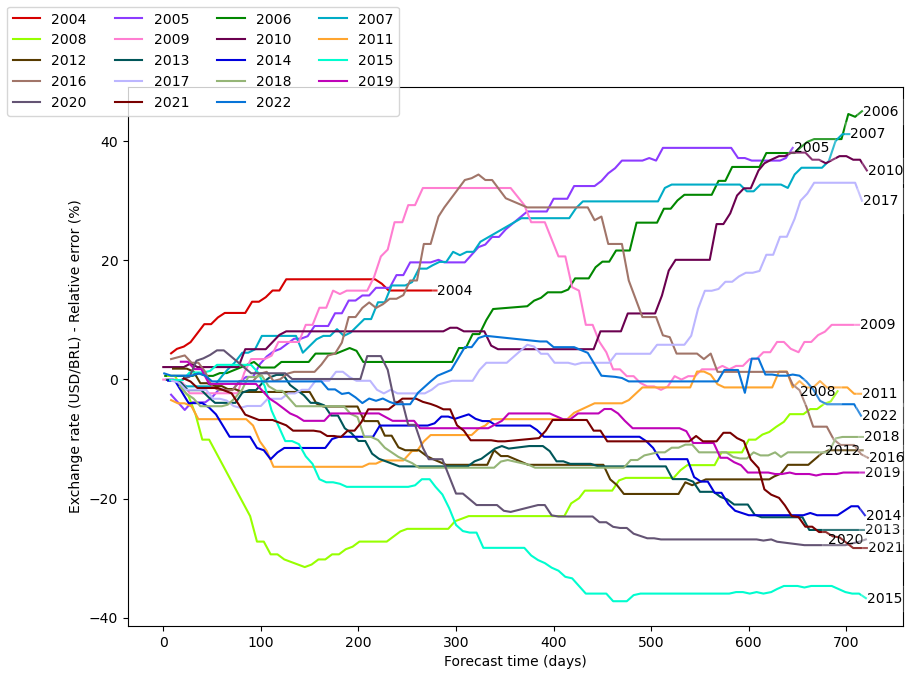

In [148]:
max_forecast = usd_mrg.loc[usd_mrg.groupby(usd_mrg.Year.dt.year)['Time_to_forecast'].idxmax()][['Year','Error_relative','Time_to_forecast']].assign(Year=usd_mrg.Year.dt.year).sort_values('Error_relative')
max_forecast['dist_plus'] = np.sqrt((max_forecast - max_forecast.shift(1))['Error_relative']**2)
max_forecast['Time_to_forecast']= max_forecast.apply(lambda x: x['Time_to_forecast']-40 if x['dist_plus']<1.5 else x['Time_to_forecast'],axis=1)
max_forecast = max_forecast.drop(['dist_plus'],axis=1).to_numpy()


fig, axes = plt.subplots(1, 1, figsize=(10,7))
sns.lineplot(usd_mrg,x='Time_to_forecast',y='Error_relative',hue=usd_mrg['Year'].dt.year,palette=palette,ax=axes)
for y,v,t in max_forecast:
    axes.text(x=t+1,y=v,s=int(y),va="center",fontsize=10, bbox=dict(edgecolor='White', facecolor='white', alpha=0.2))

h,l = axes.get_legend_handles_labels()
axes.legend_.remove()
fig.legend(flip(h,4),flip(l,4), ncol=4,loc="upper left")

axes.set_ylabel('Exchange rate (USD/BRL) - Relative error (%)');
axes.set_xlabel("Forecast time (days)");

<AxesSubplot: xlabel='Error_relative', ylabel='Count'>

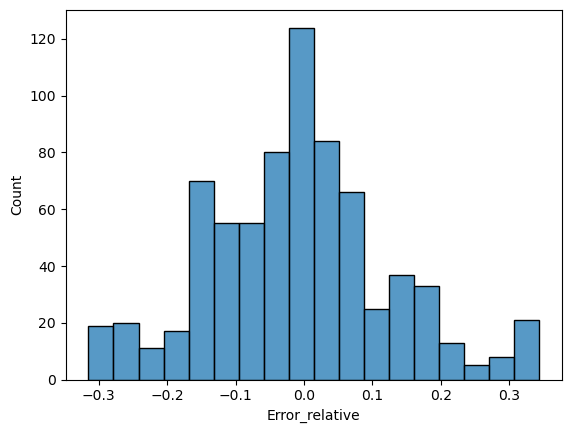

In [145]:
sns.histplot(usd_mrg[(usd_mrg['Year'].dt.year < 2019)& (usd_mrg['Time_to_forecast'] < 365)],x='Error_relative')

In [146]:
mu, std = norm.fit(usd_mrg[(usd_mrg['Year'].dt.year < 2019)& (usd_mrg['Time_to_forecast'] < 365)]['Error_relative'])
print(std)

0.13279190313032946


0.22826929546168004


<AxesSubplot: xlabel='Error_relative', ylabel='Count'>

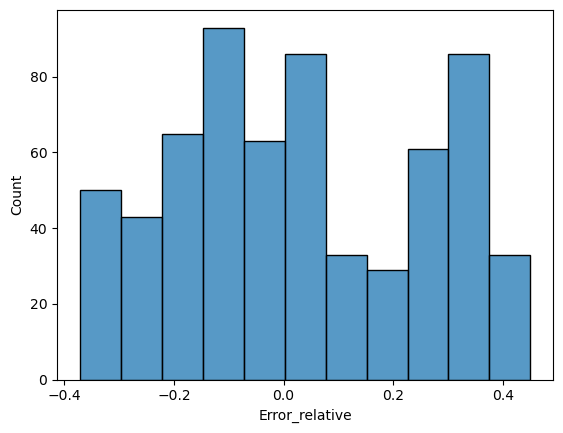

In [147]:
mu, std = norm.fit(usd_mrg[(usd_mrg['Year'].dt.year < 2018)& (usd_mrg['Time_to_forecast'] > 365)]['Error_relative'])
print(std)
sns.histplot(usd_mrg[(usd_mrg['Year'].dt.year < 2018)& (usd_mrg['Time_to_forecast'] > 365)],x='Error_relative')

In [150]:
gdp_mrg = pd.merge(data_rep[data_rep['Indicator']=='GDP'],gdp_table,how='left').dropna()
gdp_mrg['Error'] = (gdp_mrg['Value'] - gdp_mrg['GDP'])
gdp_mrg['Error_relative'] = (gdp_mrg['Value'] - gdp_mrg['GDP'])/gdp_mrg['GDP']
gdp_mrg['Time_to_forecast'] =(gdp_mrg['Year'] - gdp_mrg['Date']).dt.days

In [151]:
gdp_mrg

,Date,Indicator,Value,Year,Forecast_year_advance,OCR,GDP,Error,Error_relative,Time_to_forecast
0,2004-03-26,GDP,3.50,2004-12-31,0,0,5.8,-2.30,-0.396552,280
1,2004-03-26,GDP,3.70,2005-12-31,1,0,3.2,0.50,0.156250,645
2,2004-04-02,GDP,3.50,2004-12-31,0,0,5.8,-2.30,-0.396552,273
3,2004-04-02,GDP,3.70,2005-12-31,1,0,3.2,0.50,0.156250,638
4,2004-04-08,GDP,3.50,2004-12-31,0,0,5.8,-2.30,-0.396552,267
...,...,...,...,...,...,...,...,...,...,...
1828,2022-12-02,GDP,3.05,2022-12-31,0,0,2.9,0.15,0.051724,29
1830,2022-12-09,GDP,3.05,2022-12-31,0,0,2.9,0.15,0.051724,22
1832,2022-12-16,GDP,3.05,2022-12-31,0,0,2.9,0.15,0.051724,15
1834,2022-12-23,GDP,3.04,2022-12-31,0,0,2.9,0.14,0.048276,8


In [217]:
list_years = gdp_mrg.Year.dt.year.unique()
gdp_mrg[gdp_mrg['Year'].dt.year.isin(list_years)]

,Date,Indicator,Value,Year,Forecast_year_advance,OCR,GDP,Error,Error_relative,Time_to_forecast
0,2004-03-26,GDP,3.50,2004-12-31,0,0,5.8,-2.30,-0.396552,280
1,2004-03-26,GDP,3.70,2005-12-31,1,0,3.2,0.50,0.156250,645
2,2004-04-02,GDP,3.50,2004-12-31,0,0,5.8,-2.30,-0.396552,273
3,2004-04-02,GDP,3.70,2005-12-31,1,0,3.2,0.50,0.156250,638
4,2004-04-08,GDP,3.50,2004-12-31,0,0,5.8,-2.30,-0.396552,267
...,...,...,...,...,...,...,...,...,...,...
1828,2022-12-02,GDP,3.05,2022-12-31,0,0,2.9,0.15,0.051724,29
1830,2022-12-09,GDP,3.05,2022-12-31,0,0,2.9,0.15,0.051724,22
1832,2022-12-16,GDP,3.05,2022-12-31,0,0,2.9,0.15,0.051724,15
1834,2022-12-23,GDP,3.04,2022-12-31,0,0,2.9,0.14,0.048276,8


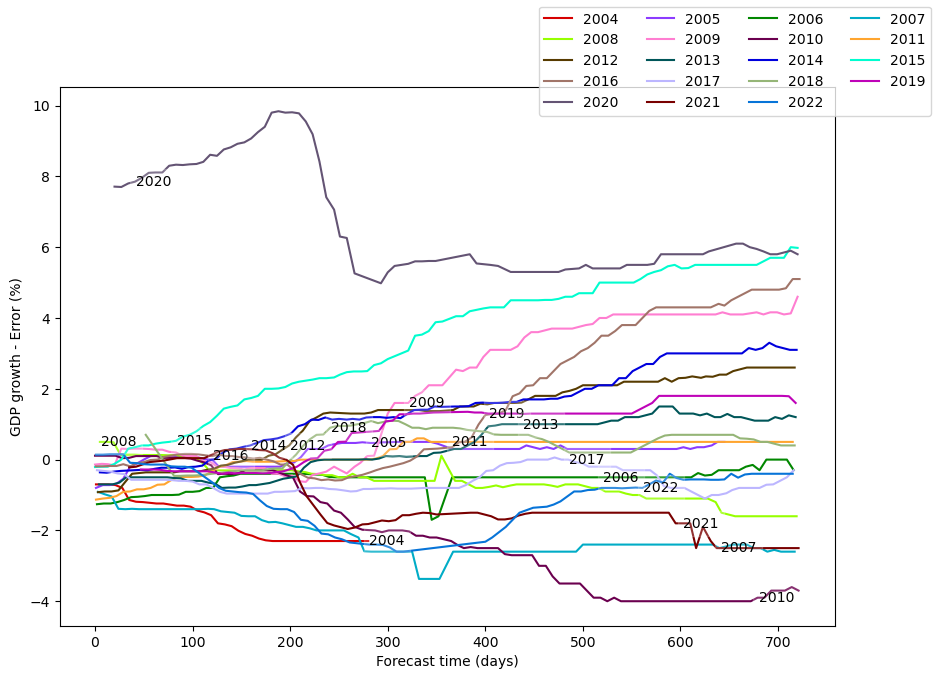

In [289]:
m_forecast = np.empty((0,3), float)
list_years = gdp_mrg['Year'].dt.year.unique()
for vlist_days in np.linspace(1,gdp_mrg['Time_to_forecast'].max(),len(list_years)):
    temp_df = gdp_mrg[gdp_mrg['Year'].dt.year.isin(list_years)].copy()
    temp_df = temp_df.iloc[(temp_df['Time_to_forecast']-vlist_days).abs().argsort()[:len(list_years)]]
    temp_df['Year'] = temp_df['Year'].dt.year
    m_forecast= np.append(m_forecast,[temp_df.loc[temp_df['Error'].idxmax()][['Year','Error','Time_to_forecast']].to_numpy()],axis=0)
    index = np.argwhere(list_years==temp_df.loc[temp_df['Error'].idxmax()]['Year'])
    list_years = np.delete(list_years, index)
m_forecast
fig, axes = plt.subplots(1, 1, figsize=(10,7))
sns.lineplot(gdp_mrg,x='Time_to_forecast',y='Error',hue=gdp_mrg['Year'].dt.year,palette=palette,ax=axes)
for y,v,t in m_forecast:
    axes.text(x=t+1,y=v,s=int(y),va="center",fontsize=10, bbox=dict(edgecolor='White', facecolor='white', alpha=0.2))

h,l = axes.get_legend_handles_labels()
axes.legend_.remove()
fig.legend(flip(h,4),flip(l,4), ncol=4,loc="upper right")

axes.set_ylabel('GDP growth - Error (%)');
axes.set_xlabel("Forecast time (days)");

In [211]:
gdp_mrg[gdp_mrg['Value']==gdp_mrg.Value.max()]

,Date,Indicator,Value,Year,GDP,Error,Error_relative,Time_to_forecast
1274,2018-11-23,GDP,61.39,2018-12-31,1.8,59.59,33.105556,38


<AxesSubplot: xlabel='Error', ylabel='Count'>

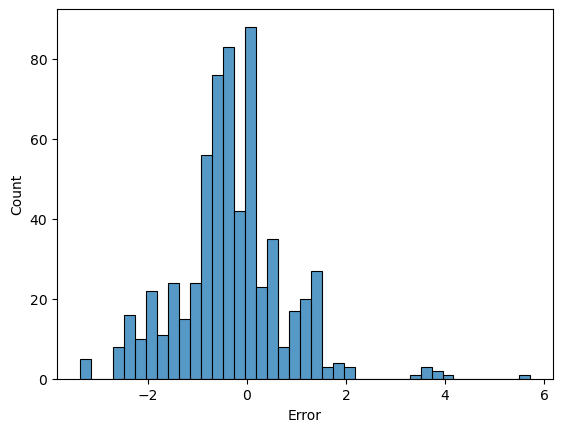

In [161]:
sns.histplot(gdp_mrg[(gdp_mrg['Year'].dt.year < 2019)& (gdp_mrg['Time_to_forecast'] < 365)],x='Error')

In [173]:
mu, std = norm.fit(gdp_mrg[(gdp_mrg['Year'].dt.year < 2019)& (gdp_mrg['Time_to_forecast'] < 365) & (gdp_mrg['Value'] < 10)]['Error'])
print(std)

1.080178028800604


<AxesSubplot: xlabel='Error', ylabel='Count'>

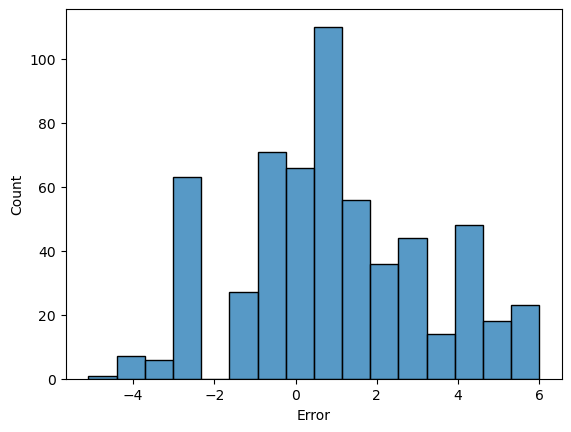

In [160]:
sns.histplot(gdp_mrg[(gdp_mrg['Year'].dt.year < 2019)& (gdp_mrg['Time_to_forecast'] > 365)],x='Error')

In [166]:
ipca_mrg = pd.merge(data_rep[data_rep['Indicator']=='IPCA'],ipca_table,how='left').dropna()
ipca_mrg['Error'] = (ipca_mrg['Value'] - ipca_mrg['IPCA'])
ipca_mrg['Error_relative'] = (ipca_mrg['Value'] - ipca_mrg['IPCA'])/ipca_mrg['IPCA']
ipca_mrg['Time_to_forecast'] =(ipca_mrg['Year'] - ipca_mrg['Date']).dt.days

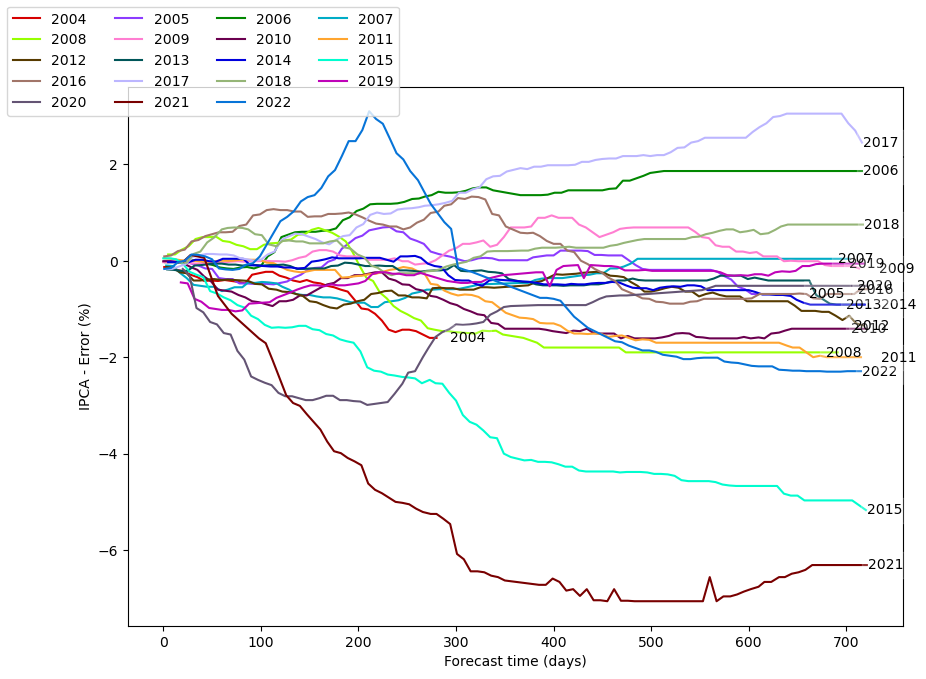

In [170]:
max_forecast = ipca_mrg.loc[ipca_mrg.groupby(ipca_mrg.Year.dt.year)['Time_to_forecast'].idxmax()][['Year','Error','Time_to_forecast']].assign(Year=ipca_mrg.Year.dt.year).sort_values('Error')
max_forecast['dist_plus'] = np.sqrt((max_forecast - max_forecast.shift(1))['Error']**2)
max_forecast['dist_neg'] = np.sqrt((max_forecast - max_forecast.shift(-1))['Error']**2)
max_forecast['Time_to_forecast']= max_forecast.apply(lambda x: x['Time_to_forecast']-random.randint(10,20) if x['dist_plus']<0.2 else  x['Time_to_forecast']+random.randint(10,20) if x['dist_neg']<0.2 else x['Time_to_forecast'],axis=1)
max_forecast = max_forecast.drop(['dist_plus','dist_neg'],axis=1).to_numpy()

fig, axes = plt.subplots(1, 1, figsize=(10,7))
sns.lineplot(ipca_mrg,x='Time_to_forecast',y='Error',hue=ipca_mrg['Year'].dt.year,palette=palette,ax=axes)
for y,v,t in max_forecast:
    axes.text(x=t+1,y=v,s=int(y),va="center",fontsize=10, bbox=dict(edgecolor='White', facecolor='white', alpha=0.2))

h,l = axes.get_legend_handles_labels()
axes.legend_.remove()
fig.legend(flip(h,4),flip(l,4), ncol=4,loc="upper left")

axes.set_ylabel('IPCA - Error (%)');
axes.set_xlabel("Forecast time (days)");

<AxesSubplot: xlabel='Error', ylabel='Count'>

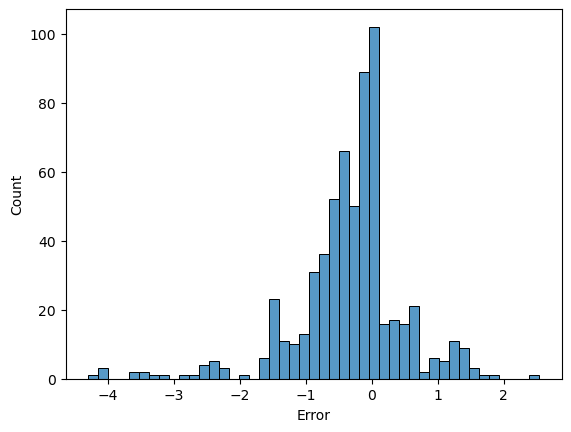

In [159]:
sns.histplot(ipca_mrg[(gdp_mrg['Year'].dt.year < 2019)& (ipca_mrg['Time_to_forecast'] < 365) ],x='Error')

In [178]:
mu, std = norm.fit(ipca_mrg[(gdp_mrg['Year'].dt.year < 2019)& (ipca_mrg['Time_to_forecast'] < 365) & (ipca_mrg['Value'] < 10)]['Error'])
print(std)

0.8479295471688998


In [221]:
## Error over time? -> std of error for 1 month with n months to conclusion date -> plot to see the behavior

[]
[('3,70', '3,78')]
[('139', '250')]
